/Users/pedromarques/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


6941
8968


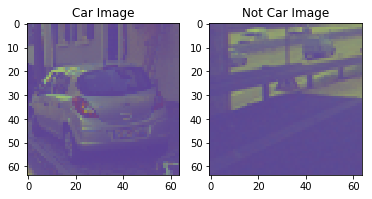

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
import cv2
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.cross_validation import train_test_split
import glob
%matplotlib inline

def read_car_not_car_images():
    car_files = glob.glob('vehicles/*.png')
    not_car_files = glob.glob('non-vehicles/*.png')
    
    print(len(car_files))
    print(len(not_car_files))
    return car_files, not_car_files

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV) 
        
cars, not_cars = read_car_not_car_images()

img = convert_color(mpimg.imread(cars[np.random.randint(0,len(cars))]))
img2 = convert_color(mpimg.imread(not_cars[np.random.randint(0,len(not_cars))]))

img_converted_color = convert_color(img)
img2 = convert_color(img2)
# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(img_converted_color)
plt.title('Car Image')
plt.subplot(122)
plt.imshow(img2)
plt.title('Not Car Image')

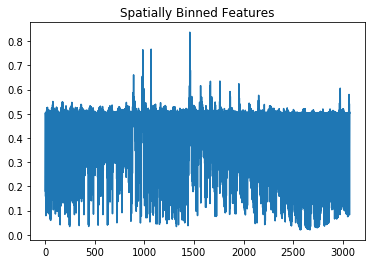

In [2]:
## Compute color histogram features ##
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to compute color histogram features  
# Pass the color_space flag as 3-letter all caps string
# like 'HSV' or 'LUV' etc.
# KEEP IN MIND IF YOU DECIDE TO USE THIS FUNCTION LATER
# IN YOUR PROJECT THAT IF YOU READ THE IMAGE WITH 
# cv2.imread() INSTEAD YOU START WITH BGR COLOR!
def bin_spatial(img, size=(32, 32)):
    # Convert image to new color space (if specified)
    #converted_img = np.copy(img)
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel()
    #features = img.ravel() # Remove this line!
    # Return the feature vector
    return features
    
feature_vec = bin_spatial(img, size=(32, 32))
plt.plot(feature_vec)
plt.title('Spatially Binned Features')

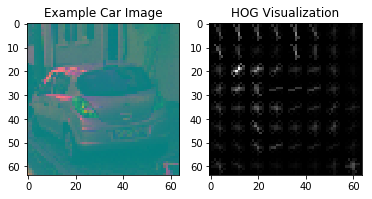

In [3]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
       # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=vis, transform_sqrt=False, feature_vector=feature_vec)
        return features, hog_image
    else:      
        # Use skimage.hog() to get features only
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=vis, transform_sqrt=False, feature_vector=feature_vec)
        return features
    
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

In [4]:
## HOG Classify ##

import time

# Function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
# Modified extract_features function

def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)


colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
box_colors = (129, 219, 215)

t=time.time()

car_features = extract_features(cars, color_space=colorspace, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(not_cars, color_space=colorspace, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

106.87 Seconds to extract HOG features...


In [5]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = len(X_test)
print('My SVC predicts: ', svc.predict(X_test))
print('For these',n_predict, 'labels: ', y_test)
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6108
16.87 Seconds to train SVC...
Test Accuracy of SVC =  0.9934
My SVC predicts:  [ 0.  1.  0. ...,  1.  1.  1.]
For these 3182 labels:  [ 0.  1.  0. ...,  1.  1.  1.]
0.04877 Seconds to predict 3182 labels with SVC


In [6]:
## Sliding Window ##

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    #print("Span of reagion to be searched in x (XSPAN):",xspan)
    #print("Span of reagion to be searched in y (YSPAN):",yspan)
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    #print("Number of pixels per set in X:", nx_pix_per_step)
    #print("Number of pixels per set in Y:", ny_pix_per_step)
    
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step)
    
    #print("Number of windows x axis:", nx_windows)
    #print("Number of windows y axis:", ny_windows)
    
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [7]:
## ##
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

Height: 360.0


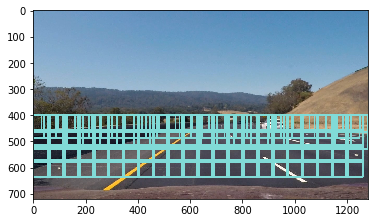

In [8]:
## ##

image = mpimg.imread('test_images/test3.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255

print("Height:",image.shape[0]/2)

y_start_stop = [int(image.shape[0]/2+40), int(image.shape[0]-40)] # Min and max in y to search in slide_window()

windows = []
"""
for size in window_sizes:
    window = slide_window(image, x_start_stop=[None, None], y_start_stop=[400,500], 
                        xy_window=(size, size), xy_overlap=(0.0, 0.0))
    windows = windows + window

window_sizes = range(86,200,32)
for size in window_sizes:
    window = slide_window(image, x_start_stop=[None, None], y_start_stop=[400,600], 
                        xy_window=(size, size), xy_overlap=(0.0, 0.0))
    windows = windows + window
"""

"""
window_sizes = range(64,280,8)
for size in window_sizes:
    window = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(size, size), xy_overlap=(0.0, 0.0))
    windows = windows + window
"""

#window_sizes = range(64,64,0)
window = slide_window(image, x_start_stop=[None, None], y_start_stop=[400,464], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5))
windows = windows + window
window = slide_window(image, x_start_stop=[None, None], y_start_stop=[400,656], 
                    xy_window=(64, 64), xy_overlap=(0.1, 0.1))
windows = windows + window
window = slide_window(image, x_start_stop=[None, None], y_start_stop=[400,528], 
                    xy_window=(86, 86), xy_overlap=(0.5, 0.5))
windows = windows + window
window = slide_window(image, x_start_stop=[None, None], y_start_stop=[400,528], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
windows = windows + window
#window = slide_window(image, x_start_stop=[None, None], y_start_stop=[400,656], 
#                    xy_window=(256, 256), xy_overlap=(0.2, 0.2))
windows = windows + window

"""
hot_windows = search_windows(image, windows, svc, X_scaler, color_space=colorspace, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       
"""
display_images = []
window_img = draw_boxes(draw_image, windows, color=box_colors, thick=6)                    
#hot_img = draw_boxes(draw_image, hot_windows, color=box_colors, thick=6)
display_images.append(window_img)
#display_images.append(hot_img)
for ima in display_images:
    plt.figure()
    plt.imshow(ima)

    #plt.imshow(window_img)                   

#plt.imshow(window_img)

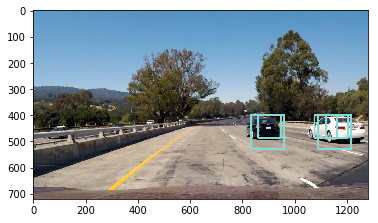

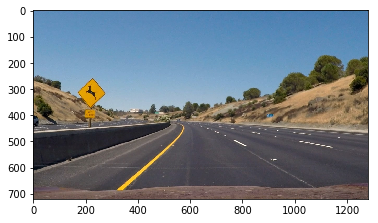

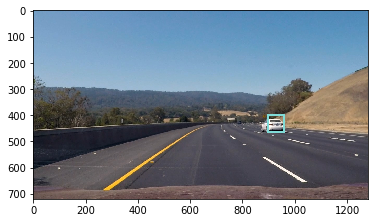

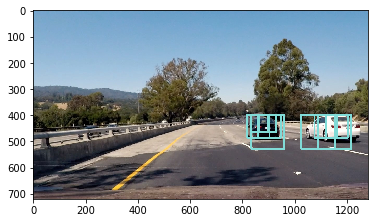

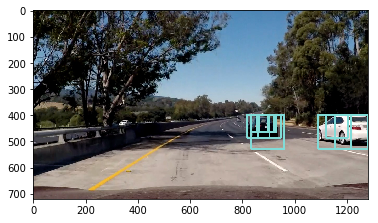

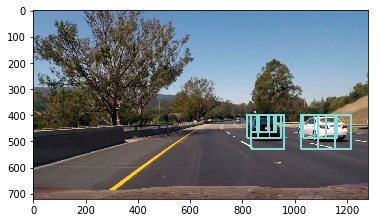

In [9]:
def find_cars2(img, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, windows):
    
    img = img.astype(np.float32)/255
    
    ctrans_tosearch = convert_color(img, conv='RGB2YCrCb')
    
    box_list = []
    for window in windows:
        # Extract the image patch
        subimg = cv2.resize((ctrans_tosearch[window[0][1]: window[1][1], window[0][0]: window[1][0]]),(64,64))

        # Extract hog features for that window 
        hog_features = []
        for channel in range(subimg.shape[2]):
            hog_features.append(get_hog_features(subimg[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=False))
        hog_features = np.ravel(hog_features)

        # Get color features
        spatial_features = bin_spatial(subimg, size=spatial_size)
        hist_features = color_hist(subimg, nbins=hist_bins)
            
        # Scale features and make a prediction
        test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
        #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
        test_prediction = svc.predict(test_features)

        # If it is a positive match means this window contains car features, so append it
        if test_prediction == 1:
            box_list.append(window)
                
    return box_list

# Read in all the image filenames
test_image_files = glob.glob('test_images/*.jpg')

detected_images = []
for filename in test_image_files:
    # Read in the image
    image = mpimg.imread(filename)
    draw_image = np.copy(image)
    
    # Find the cars on the image and save the bounding boxes for each car detected
    box_list = find_cars2(image, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, windows)

    # Draw the detected car boxes on the image
    out_img = draw_boxes(draw_image, box_list, color=box_colors, thick=6)
    
    # Append the original image and the bounding boxes list to an array for future usage
    detected_images.append((image, box_list))
    
    # Display the image with the windows where car features were detected
    plt.figure()
    plt.imshow(out_img)

[((832, 400), (959, 527)), ((1075, 400), (1215, 527))]
deque([[[((832, 400), (959, 527)), ((1075, 400), (1215, 527))]]], maxlen=20)
Not enough boxes to use the group rectangle function: <built-in function groupRectangles> returned NULL without setting an error
[]
deque([[[((832, 400), (959, 527)), ((1075, 400), (1215, 527))]], [[]]], maxlen=20)
Not enough boxes to use the group rectangle function: <built-in function groupRectangles> returned NULL without setting an error
[((896, 400), (959, 463))]
deque([[[((832, 400), (959, 527)), ((1075, 400), (1215, 527))]], [[]], [[((896, 400), (959, 463))]]], maxlen=20)
Not enough boxes to use the group rectangle function: <built-in function groupRectangles> returned NULL without setting an error
[((817, 400), (959, 527)), ((1024, 400), (1215, 527))]
deque([[[((832, 400), (959, 527)), ((1075, 400), (1215, 527))]], [[]], [[((896, 400), (959, 463))]], [[((817, 400), (959, 527)), ((1024, 400), (1215, 527))]]], maxlen=20)
Not enough boxes to use the g

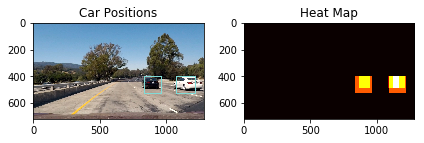

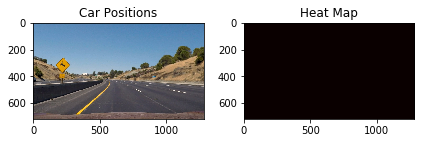

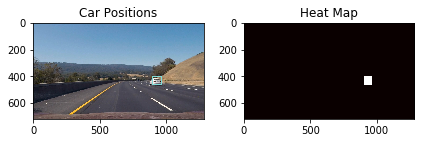

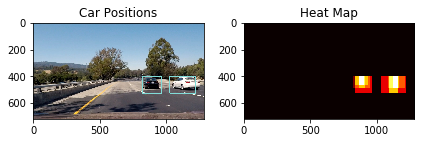

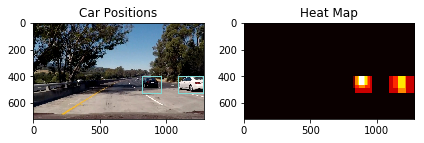

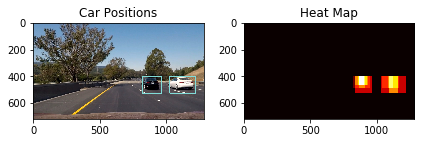

In [10]:
## Detect the vehicles using heatmap ##
# Big thanks to Andreas Daiminger for helping me figure this out #
# Also http://www.pyimagesearch.com/2014/04/21/building-pokedex-python-finding-game-boy-screen-step-4-6/ for how to use the findCountours method #
from collections import deque
import sys
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    detected_cars = []
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        detected_cars.append(bbox)
        # Draw the box on the image
        #cv2.rectangle(img, bbox[0], bbox[1], (129, 219, 215), 6)
    # Return the image
    return detected_cars

number_of_frames = 20
buffer = deque(maxlen=number_of_frames)
for image,box_list in detected_images:
    # Read in image similar to one shown above 
    #image = mpimg.imread('bbox-example-image.jpg')
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,box_list)
   
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,0)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)

    drawn_boxes = draw_labeled_bboxes(np.copy(image), labels)

    result2 = np.copy(image)
    
    buffer.append([drawn_boxes])
    print(drawn_boxes)
    print(buffer)

    # get last boxes
    last_boxes = np.array(buffer).tolist()

    try:
        rects,weights = cv2.groupRectangles(last_boxes, 3, 0.1)
        for rect in rects:
            #cv2.rectangle(result2, (rect[0], rect[1]), (rect[2],rect[3]), (129, 219, 215), 5)
            result2 = draw_boxes(np.copy(image), rect, color=box_colors, thick=6)
            
    except SystemError as e:
        print("Not enough boxes to use the group rectangle function:", e)
        result2 = draw_boxes(np.copy(image), drawn_boxes, color=box_colors, thick=6)
        pass   

    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(result2)
    plt.title('Car Positions')
    plt.subplot(122)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    fig.tight_layout()

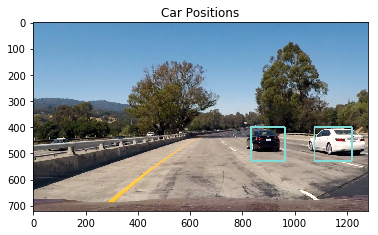

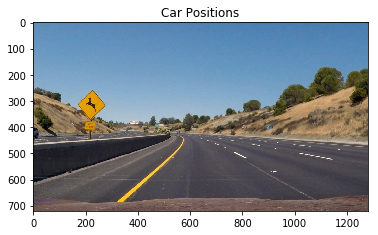

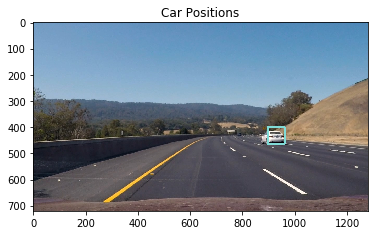

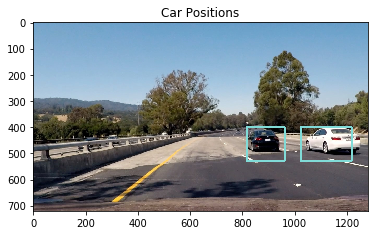

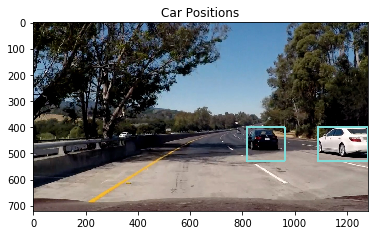

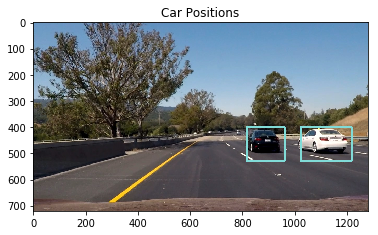

In [11]:
## Detect vehicle by drawing its boxes on a blank image ##
def detect_vehicles_using_mask():
    path='output_images/'
    image_prefix='output_img'
    extension='.jpg'
    i=0
    for image,box_list in detected_images:
        # Make a copy of the original image to draw the final box on
        result = np.copy(image)
        
        # Create a blank image to draw all the overlapping boxes on
        mask = np.zeros_like(image)

        # Draw the boxes on the blank image
        mask = draw_boxes(mask, bboxes=box_list, thick=-1)

        # Find the outline of the drawn boxes
        unused_img, outlines, hrc = cv2.findContours(mask[:,:,2].astype('uint8'),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        for outline in outlines:
            # Find the position and size of the outlined box
            x,y,width,height = cv2.boundingRect(outline)
            
            # Draw the rectangle on the image
            cv2.rectangle(result, (x, y), (x + width, y + height), (box_colors), 6)
            
        fig = plt.figure()
        plt.title('Car Positions')
        plt.imshow(result)
        mpimg.imsave(path+image_prefix+str(i)+extension, result)
        i=i+1
detect_vehicles_using_mask()

In [13]:
## Apply vehicle detection on video using heat and labels - improved ##

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Read in an image from the video stream
image = mpimg.imread('test_images/test5.jpg')

# I have decided to create the windows before going through the video to improve performance, otherwise for each new
# frame I would have to again create the windows, wasting time.
windows = []

#window = slide_window(image, x_start_stop=[None, None], y_start_stop=[400,464], 
#                    xy_window=(64, 64), xy_overlap=(0.5, 0.5))
#windows = windows + window
window = slide_window(image, x_start_stop=[None, None], y_start_stop=[400,656], 
                    xy_window=(64, 64), xy_overlap=(0.1, 0.1))
windows = windows + window
window = slide_window(image, x_start_stop=[None, None], y_start_stop=[400,528], 
                    xy_window=(86, 86), xy_overlap=(0.5, 0.5))
windows = windows + window
window = slide_window(image, x_start_stop=[None, None], y_start_stop=[400,528], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
windows = windows + window
#window = slide_window(image, x_start_stop=[None, None], y_start_stop=[400,656], 
#                    xy_window=(256, 256), xy_overlap=(0.2, 0.2))
#windows = windows + window

# Total number of boxes to keep in the buffer
number_of_frames = 20
buffer = deque(maxlen=number_of_frames)    

def add_labeled_bboxes_to_buffer(img, labels, buffer):

    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        #bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Append the bounding box to the buffer
        buffer.append([np.min(nonzerox), np.min(nonzeroy), np.max(nonzerox), np.max(nonzeroy)])

def detect_vehicle_video(image):
    
    result = np.copy(image)
    
    box_list = find_cars2(image, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, windows)
    
    # Create a blank image
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,box_list)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,0)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)

    # Add the detected car boxes to the buffer to smooth
    add_labeled_bboxes_to_buffer(result, labels, buffer)
    

    # get last boxes
    last_boxes = np.array(buffer).tolist()
    # Group the similar boxes detected, if not enough boxes are stored in the buffer draw the ones detected right now
    try:
        rects,weights = cv2.groupRectangles(last_boxes, 3, 0.1)
        for rect in rects:
            cv2.rectangle(result, (rect[0], rect[1]), (rect[2],rect[3]), (box_colors), 6)
            #result2 = draw_boxes(np.copy(image), rect, color=box_colors, thick=6)
    except SystemError as e:
        ###print("Error, not enough boxes to use the group rectangle function:", e)
        drawn_boxes = draw_labeled_bboxes(result, labels)
        result = draw_boxes(result, drawn_boxes, color=box_colors, thick=6)
        pass
    return result
    

output = 'project_heatmap.mp4'
clip = VideoFileClip('project_video.mp4')

output_clip = clip.fl_image(detect_vehicle_video)
output_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_heatmap.mp4
[MoviePy] Writing video project_heatmap.mp4



100%|█████████▉| 1260/1261 [14:06<00:00,  1.46it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_heatmap.mp4 



In [14]:
## Apply vehicle detection on video using mask and box outlines ##

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Read in an image from the video stream
image = mpimg.imread('test_images/test5.jpg')

# I have decided to create the windows before going through the video to improve performance, otherwise for each new
# frame I would have to again create the windows, wasting time.
windows = []

window = slide_window(image, x_start_stop=[None, None], y_start_stop=[400,464], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5))
windows = windows + window
window = slide_window(image, x_start_stop=[None, None], y_start_stop=[400,656], 
                    xy_window=(64, 64), xy_overlap=(0.1, 0.1))
windows = windows + window
window = slide_window(image, x_start_stop=[None, None], y_start_stop=[400,528], 
                    xy_window=(86, 86), xy_overlap=(0.5, 0.5))
windows = windows + window
window = slide_window(image, x_start_stop=[None, None], y_start_stop=[400,528], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
windows = windows + window
#window = slide_window(image, x_start_stop=[None, None], y_start_stop=[400,656], 
#                    xy_window=(256, 256), xy_overlap=(0.2, 0.2))
#windows = windows + window

# Total number of boxes to keep in the buffer
number_of_frames = 20
buffer = deque(maxlen=number_of_frames)    

def detect_vehicle_video(image):
    
    result = np.copy(image)
    
    box_list = find_cars2(image, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, windows)
    
    ### DETECT USING MASK IMAGE##
    # Make a copy of the original image to draw the final box on
    result = np.copy(image)
    
    # Create a blank image to draw all the overlapping boxes on
    mask = np.zeros_like(image)

    # Draw the boxes on the blank image
    mask = draw_boxes(mask, bboxes=box_list, thick=-1)

    # Find the outline of the drawn boxes
    unused_img, outlines, hrc = cv2.findContours(mask[:,:,2].astype('uint8'),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    for outline in outlines:
        # Find the position and size of the outlined box
        x,y,width,height = cv2.boundingRect(outline)

        # Append the detected car box to the buffer
        buffer.append([x, y, x+width, y+height])
    
    # get the last boxes
    last_boxes = np.array(buffer).tolist()
    
    # Group the similar boxes together and draw each one of them
    rectangles,w = cv2.groupRectangles(last_boxes, 3, 0.1)
    
    for rectangle in rectangles:
        cv2.rectangle(result, (rectangle[0], rectangle[1]), (rectangle[2], rectangle[3]), box_colors, 6)
    
    return result

output = 'project.mp4'
clip = VideoFileClip('project_video.mp4')

output_clip = clip.fl_image(detect_vehicle_video)
output_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project.mp4
[MoviePy] Writing video project.mp4



100%|█████████▉| 1260/1261 [18:40<00:00,  1.04it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project.mp4 



[MoviePy] >>>> Building video project_with_lanes.mp4
[MoviePy] Writing video project_with_lanes.mp4



100%|█████████▉| 1260/1261 [04:54<00:00,  4.59it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_with_lanes.mp4 



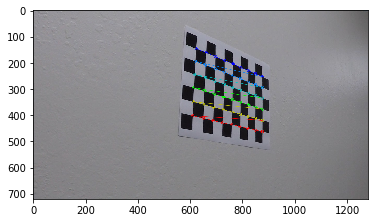

In [15]:
## Detect lane lines on the project video ##

# Import the package for lane line detection
import lane_finding
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Calibrate the camera
ret, mtx, dist, rvecs, tvecs = lane_finding.calibrate_camera('camera_cal/calibration*.jpg')

def process_image(image):
    # Undistort the image
    image = lane_finding.undistort_image(image, mtx, dist)

    # Perform perspective transformation
    warped_im, Minv = lane_finding.warp(image)

    # Perform color and gradients thresholding

    # HLS and Sobelx Gradient combined
    #combined_binary, color_binary = hls_sobel_x_gradient(warped_im)

    # HLS and LAB thresholding combined
    combined_binary = lane_finding.hls_lab_threshold(warped_im)

    # Perform the sliding window search when unsure
    out_img, ploty, left_fitx, right_fitx, left_fit, right_fit = lane_finding.sliding_window_search(combined_binary)
    #out_img, ploty, left_fitx, right_fitx, left_fit, right_fit, left_lane_inds, right_lane_inds = sliding_window_search(combined_binary)

    # NEED TO ARRANGE THIS IN A BETTER FASHION
    # If you are pretty sure where that the sliding window search is working good, you can skip it for the next frame
    # out_img, ploty, left_fitx, right_fitx = skip_sliding_window_search(combined_binary)

    # It's now ready to draw the detected lane lines on the original undistorted image
    img = lane_finding.draw_detected_lane_lines(combined_binary, image, left_fitx, right_fitx, ploty, Minv)

    # Calculate the radius of the curvature
    #left_curverad, right_curverad, distance_from_center = calculate_curvature_radius(combined_binary, ploty, left_fit, right_fit, leftx, rightx, lefty, righty)
    #left_curverad, right_curverad, distance_from_center = calc_curv_rad_and_center_dist(combined_binary, left_fit, right_fit, left_lane_inds, right_lane_inds )
    left_curverad, right_curverad, distance_from_center = lane_finding.calculate_curvature_radius2(combined_binary, ploty, left_fit, right_fit)
    # And finally draw the radius of the curvature and the distance of the car from the center
    img = lane_finding.draw_curvature_radius_information(img, left_curverad, right_curverad, distance_from_center)

    return img

output = 'project_with_lanes.mp4'
clip = VideoFileClip('project.mp4')

output_clip = clip.fl_image(process_image)
output_clip.write_videofile(output, audio=False)